In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path

import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs
# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


## out of sample (true distribition)

In [3]:

# -------- Insert your code here -------- #
filename_save_out = 'scen_out'
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios
    y = np.zeros((Nout, 50))
    Losses_out = np.zeros((Nout, K)) ##100000 *100


    for s in range(1, Nout + 1):
        x = np.random.normal(0,1,(50, 1)) ##generate 50 random numbers from sd normal distribution
        # y = L * X
        # cov = L * L^t
        y[s-1,:] = np.dot(sqrt_rho, x).T
        z = np.random.normal(0,1,(K,1))
        
        for j in range(K): #loop in each counterparty
            credit_driver = int(driver[j])
            ## creditworthiness wj = Bj*yj(k)+ sqrt(1-Bj^2)* zj
            w = beta[j] * y[s-1,credit_driver-1] + np.sqrt(1 - beta[j]**2) * z[j]
            
            temp = sorted(np.append(w, CS_Bdry[j,:]))  ## put w into cs bdy
            cs_index = np.argwhere(temp == w) ##find column for sparsed matrix of loss out
            # Calculated out-of-sample losses (100000 x 100)
            # Losses_out (sparse matrix)
            Losses_out[s-1,j] = exposure[j,cs_index]



In [4]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        loss_1d = sorted(np.dot(Losses_out,x0[portN])) #sort the loss value in increasing order
        #Compute Historical 1-day VaR from the data
        VaRout[portN, q] = loss_1d[int(math.ceil(Nout * alf)) -1]
        ##Compute Normal 1-day VaR from the data
        VaRinN[portN, q] = np.mean(loss_1d) + scs.norm.ppf(alf) * np.std(loss_1d)
        
        #Compute Historical 1-day CVaR from the data
        CVaRout[portN, q] = (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN,q] + sum(loss_1d[int(math.ceil(Nout * alf)):]))
        #Compute Normal 1-day CVaR from the data
        CVaRinN[portN, q] = np.mean(loss_1d) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(loss_1d)



## in sample scenarios 

In [5]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)


for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1
    # -------- Insert your code here -------- #
    y_1 = np.zeros((np.int32(np.ceil(Nin / Ns)),50))  #1000*50
    
    Losses_inMC1 = np.zeros((Nin,K)) #5000*100
  
    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        x = np.random.normal(0,1,(50,1))
        y_1[s-1,:] = np.dot(sqrt_rho,x).T
        
        
        for si in range(1, Ns + 1): #idiosyncratic scenarios for each systemic
            z_1 = np.random.normal(0,1,(K,1))
            # -------- Insert your code here -------- #
            for j in range(K):
                credit_driver = int(driver[j]) #find the credit driver
                w_1 = beta[j] * y_1[s-1,credit_driver-1] + np.sqrt(1 - beta[j]**2) * z_1[j]
                temp1 = sorted(np.append(w_1, CS_Bdry[j,: ]))
                cs_index = np.argwhere(temp1 == w_1)
                Losses_inMC1[5*(s-1)+si-1,j] = exposure[j,cs_index]
    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1


    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    y_2 = np.zeros((Nin,50))  ##5000*50
    
    Losses_inMC2 = np.zeros((Nin,K))# 5000*100


    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        x = np.random.normal(0,1,(50,1))
        y_2[s-1,:] = np.dot(sqrt_rho,x).T
        z_2 = np.random.normal(0,1,(K,1))
    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
        for j in range(K): #loop in each counterparty
            credit_driver = int(driver[j])
            ## creditworthiness wj = Bj*yj(k)+ sqrt(1-Bj^2)* zj
            w_2 = beta[j] * y[s-1,credit_driver-1] + np.sqrt(1 - beta[j]**2) * z[j]
            
            temp2 = sorted(np.append(w_2, CS_Bdry[j,:]))  ## put w into cs bdy
            cs_index = np.argwhere(temp2 == w_2)
            Losses_inMC2[s-1,j] = exposure[j,cs_index]



    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_inMC1,x0[portN]))# #sort the loss value in increasing order
            portf_loss_inMC2 = sorted(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            
            #VAR from simulation modelling
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]                                              
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]
            
            #VAR for normally distributed losses
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            
            #CVAR from simulation modelling
            CVaRinMC1[portN, q][tr - 1] =(1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
        
            #CVAR for normally distributed losses 
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC2

# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))




Portfolio 1:

Out-of-sample: VaR 99.0% = $37058388.88, CVaR 99.0% = $44380478.51
In-sample MC1: VaR 99.0% = $37220034.12, CVaR 99.0% = $44615312.95
In-sample MC2: VaR 99.0% = $9695313.06, CVaR 99.0% = $19870034.55
In-sample No: VaR 99.0% = $26063214.57, CVaR 99.0% = $28939551.48
In-sample N1: VaR 99.0% = $26195157.75, CVaR 99.0% = $29083205.15
In-sample N2: VaR 99.0% = $8637021.77, CVaR 99.0% = $9644101.50

Out-of-sample: VaR 99.9% = $53959872.96, CVaR 99.9% = $62024639.78
In-sample MC1: VaR 99.9% = $53619651.33, CVaR 99.9% = $60791919.56
In-sample MC2: VaR 99.9% = $32021605.40, CVaR 99.9% = $40337639.42
In-sample No: VaR 99.9% = $32547154.36, CVaR 99.9% = $34897155.28
In-sample N1: VaR 99.9% = $32705495.75, CVaR 99.9% = $35065064.28
In-sample N2: VaR 99.9% = $10907216.31, CVaR 99.9% = $11730012.24


Portfolio 2:

Out-of-sample: VaR 99.0% = $27070457.21, CVaR 99.0% = $33032372.21
In-sample MC1: VaR 99.0% = $27430240.99, CVaR 99.0% = $33432181.27
In-sample MC2: VaR 99.0% = $17224280.89

In [7]:
# Plot results (6 plots, 2 portfolios & 3 scenarios)
# Figure (1):
# -------- Insert your code here -------- #
# Figure (2):
# -------- Insert your code here -------- #

## Loss distribution of MC1, portfolio1

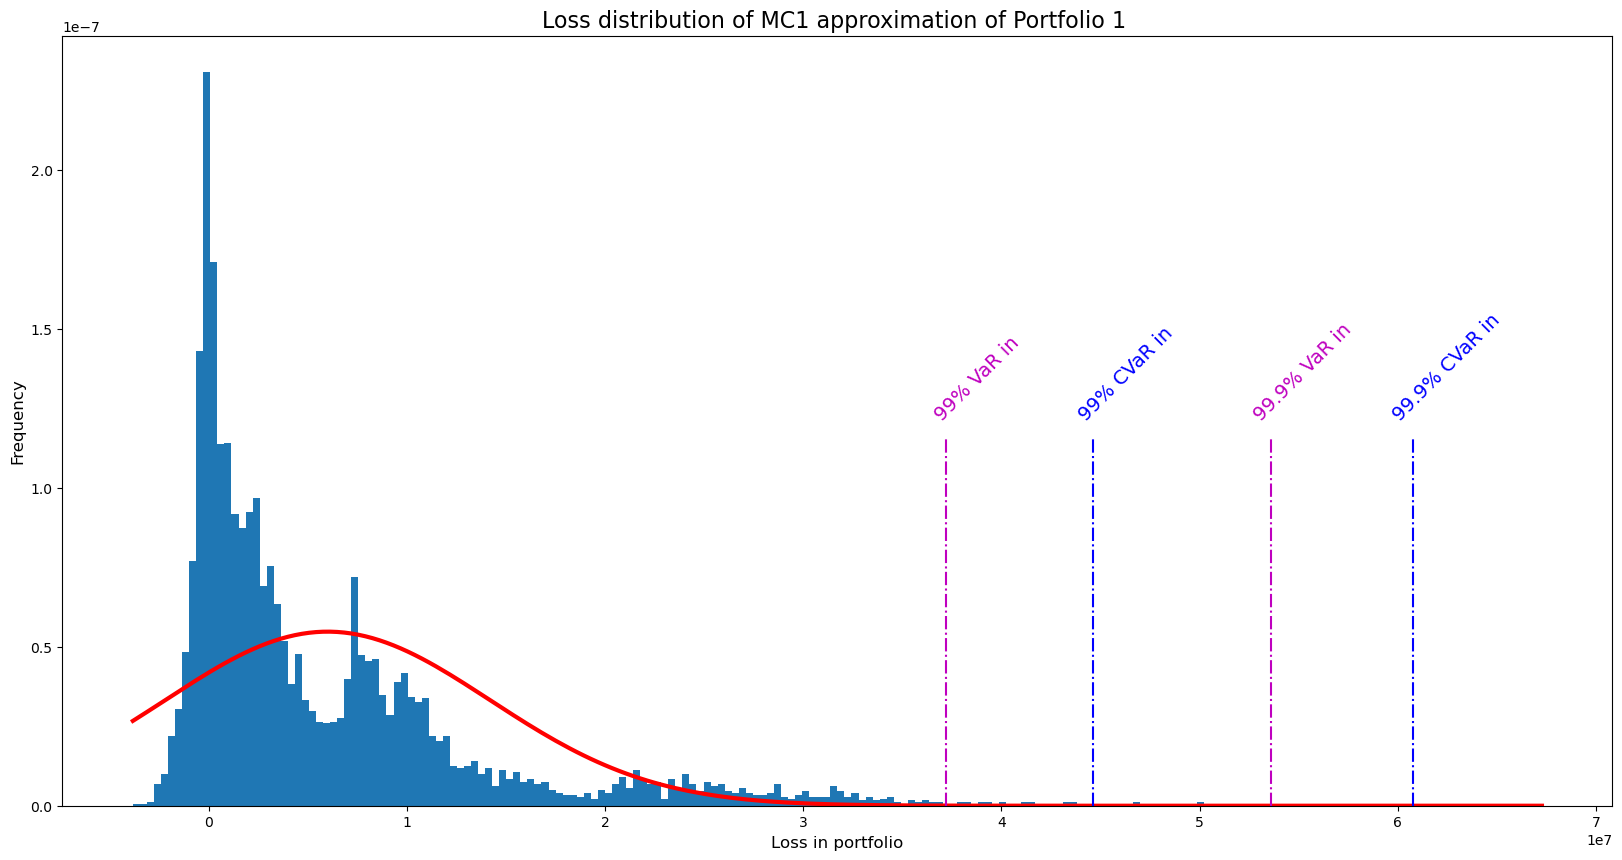

In [55]:
##Loss distribution of MC1, portfolio1
# Figure (1):
fig = plt.figure(figsize=(20,10))
count, bins, ignored = plt.hist(np.dot(Losses_inMC1,x0[0]), 200, density=True) # In your plot, you need to use Loss * X0[] to replace s
# Plot the Normal curve 
norm = (1/(np.std(np.dot(Losses_inMC1,x0[0]))*math.sqrt(2*math.pi))) * np.exp(-0.5*((bins-np.mean(np.dot(Losses_inMC1,x0[0])))/np.std(np.dot(Losses_inMC1,x0[0])))**2)
norm = norm * sum(count) / sum(norm)
plt.plot(bins, norm, color='r', linewidth= 3)

#non - normal approximation
#99 VaR
plt.plot([np.mean(VaRinMC1[0, 0]), np.mean(VaRinMC1[0, 0])],[0,max(count)/2],color='m',linewidth=1.5,linestyle='-.')
# 99.9 VaR
plt.plot([np.mean(VaRinMC1[0, 1]), np.mean(VaRinMC1[0, 1])], [0, max(count)/2], color='m',linewidth=1.5,linestyle='-.')
# 99 CVaR
plt.plot([np.mean(CVaRinMC1[0, 0]), np.mean(CVaRinMC1[0, 0])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')
#99.9 CVaR
plt.plot([np.mean(CVaRinMC1[0, 1]), np.mean(CVaRinMC1[0, 1])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')

#text
plt.text( 0.98*np.mean(VaRinMC1[0, 0]), max(count)/1.9, '99% VaR in ',fontsize=14, rotation=45,color='m')
plt.text(0.98 *np.mean(VaRinMC1[0, 1]), max(count) / 1.9, '99.9% VaR in',fontsize=14, rotation=45,color='m')
plt.text( 0.98* np.mean(CVaRinMC1[0, 0]), max(count)/1.9, '99% CVaR in',fontsize=14, rotation=45,color='b')
plt.text( 0.98* np.mean(CVaRinMC1[0, 1]), max(count)/1.9, '99.9% CVaR in',fontsize=14, rotation=45,color='b')

plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of MC1 approximation of Portfolio 1 ',fontsize=16)
plt.show()



## loss distribution of MC1, portfolio2

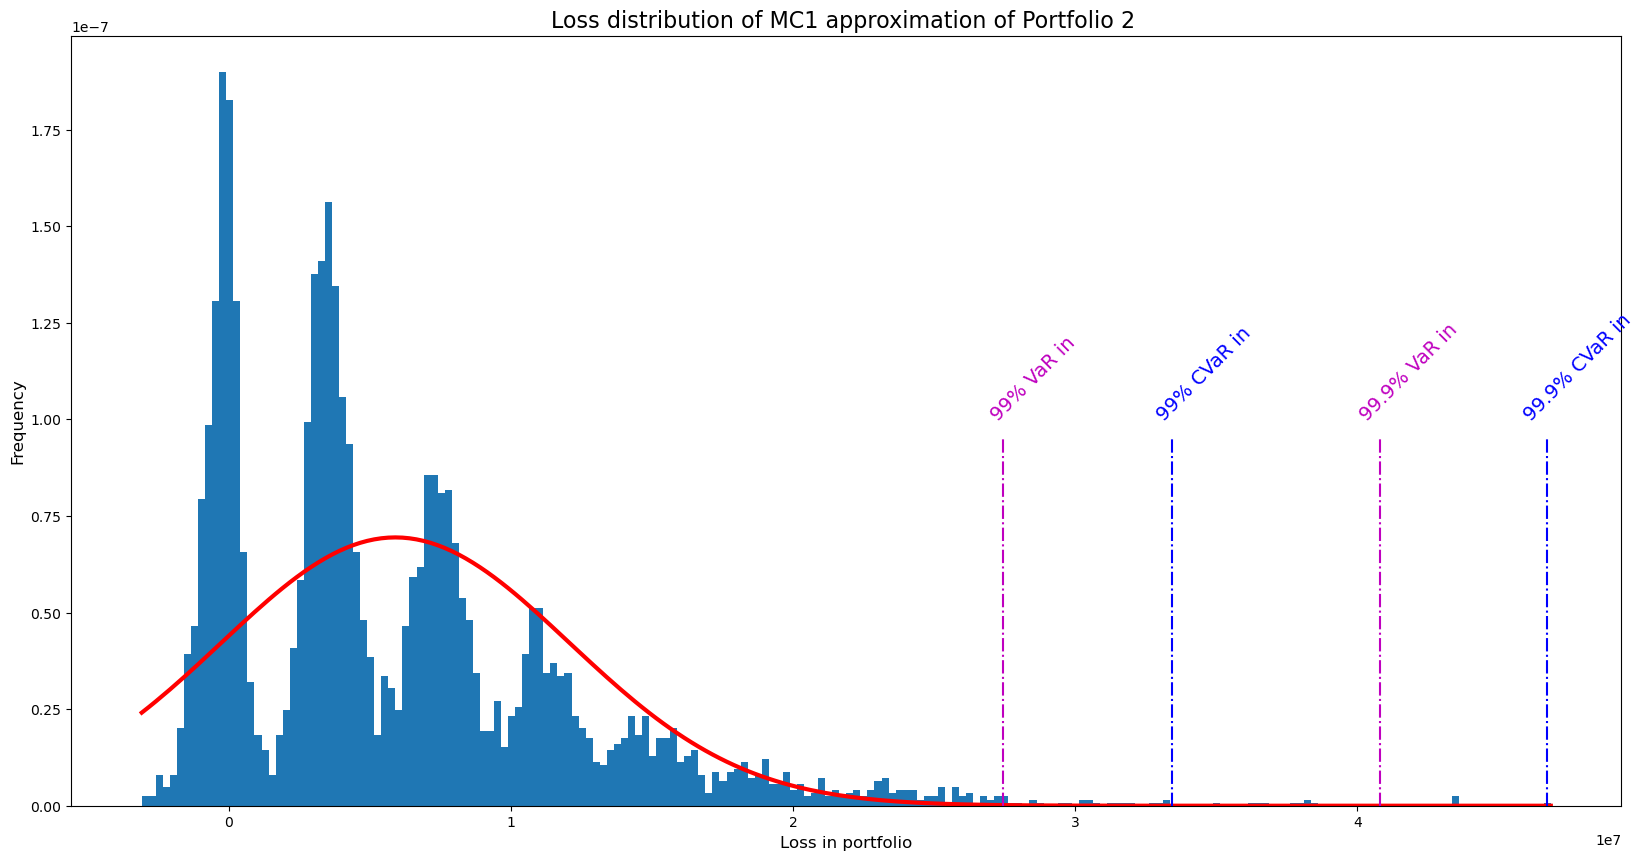

In [59]:
#from posixpath import normpath
fig = plt.figure(figsize=(20,10))
count, bins, ignored = plt.hist(np.dot(Losses_inMC1,x0[1]), 200, density=True) # In your plot, you need to use Loss * X0[] to replace s
# Plot the Normal curve 
norm = (1/(np.std(np.dot(Losses_inMC1,x0[1]))*math.sqrt(2*math.pi))) * np.exp(-0.5*((bins-np.mean(np.dot(Losses_inMC1,x0[1])))/np.std(np.dot(Losses_inMC1,x0[1])))**2)
norm = norm * sum(count) / sum(norm)
plt.plot(bins, norm, color='r', linewidth= 3)

# non normal distribution
#99 VaR
plt.plot([np.mean(VaRinMC1[1, 0]), np.mean(VaRinMC1[1, 0])],[0,max(count)/2],color='m',linewidth=1.5,linestyle='-.')
# 99.9 VaR
plt.plot([np.mean(VaRinMC1[1, 1]), np.mean(VaRinMC1[1, 1])], [0, max(count)/2], color='m',linewidth=1.5,linestyle='-.')
# 99 CVaR
plt.plot([np.mean(CVaRinMC1[1, 0]), np.mean(CVaRinMC1[1, 0])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')
#99.9 CVaR
plt.plot([np.mean(CVaRinMC1[1, 1]), np.mean(CVaRinMC1[1, 1])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')

#text
plt.text( 0.98*np.mean(VaRinMC1[1, 0]), max(count)/1.9, '99% VaR in ',fontsize=14, rotation=45,color='m')
plt.text(0.98 *np.mean(VaRinMC1[1, 1]), max(count) / 1.9, '99.9% VaR in',fontsize=14, rotation=45,color='m')
plt.text( 0.98* np.mean(CVaRinMC1[1, 0]), max(count)/1.9, '99% CVaR in',fontsize=14, rotation=45,color='b')
plt.text( 0.98* np.mean(CVaRinMC1[1, 1]), max(count)/1.9, '99.9% CVaR in',fontsize=14, rotation=45,color='b')

plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of MC1 approximation of Portfolio 2 ',fontsize=16)
plt.show()



## loss distriibution in MC2, portfolio 1

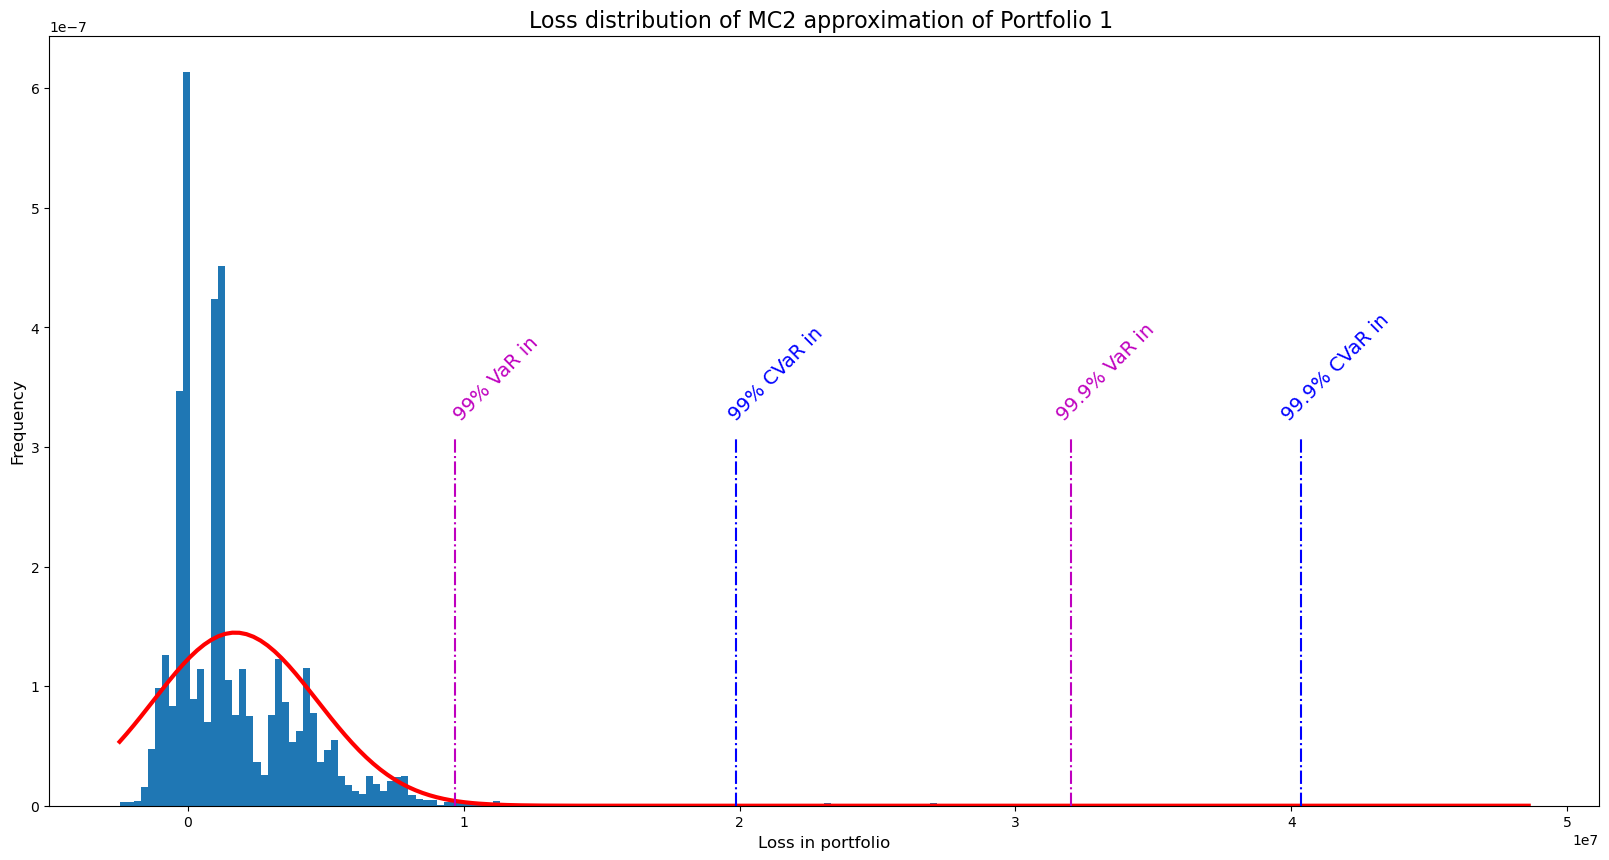

In [58]:
fig = plt.figure(figsize=(20,10))
count, bins, ignored = plt.hist(np.dot(Losses_inMC2,x0[0]), 200, density=True) # In your plot, you need to use Loss * X0[] to replace s
# Plot the Normal curve 
norm = (1/(np.std(np.dot(Losses_inMC2,x0[0]))*math.sqrt(2*math.pi))) * np.exp(-0.5*((bins-np.mean(np.dot(Losses_inMC2,x0[0])))/np.std(np.dot(Losses_inMC2,x0[0])))**2)
norm = norm * sum(count) / sum(norm)
plt.plot(bins, norm, color='r', linewidth= 3)

#non - normal approximation
#99 VaR
plt.plot([np.mean(VaRinMC2[0, 0]), np.mean(VaRinMC2[0, 0])],[0,max(count)/2],color='m',linewidth=1.5,linestyle='-.')
# 99.9 VaR
plt.plot([np.mean(VaRinMC2[0, 1]), np.mean(VaRinMC2[0, 1])], [0, max(count)/2], color='m',linewidth=1.5,linestyle='-.')
# 99 CVaR
plt.plot([np.mean(CVaRinMC2[0, 0]), np.mean(CVaRinMC2[0, 0])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')
#99.9 CVaR
plt.plot([np.mean(CVaRinMC2[0, 1]), np.mean(CVaRinMC2[0, 1])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')

#text
plt.text( 0.98*np.mean(VaRinMC2[0, 0]), max(count)/1.9, '99% VaR in ',fontsize=14, rotation=45,color='m')
plt.text(0.98 *np.mean(VaRinMC2[0, 1]), max(count) / 1.9, '99.9% VaR in',fontsize=14, rotation=45,color='m')
plt.text( 0.98* np.mean(CVaRinMC2[0, 0]), max(count)/1.9, '99% CVaR in',fontsize=14, rotation=45,color='b')
plt.text( 0.98* np.mean(CVaRinMC2[0, 1]), max(count)/1.9, '99.9% CVaR in',fontsize=14, rotation=45,color='b')

plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of MC2 approximation of Portfolio 1 ',fontsize=16)
plt.show()



## Loss distribution in MC2, portfolio 2

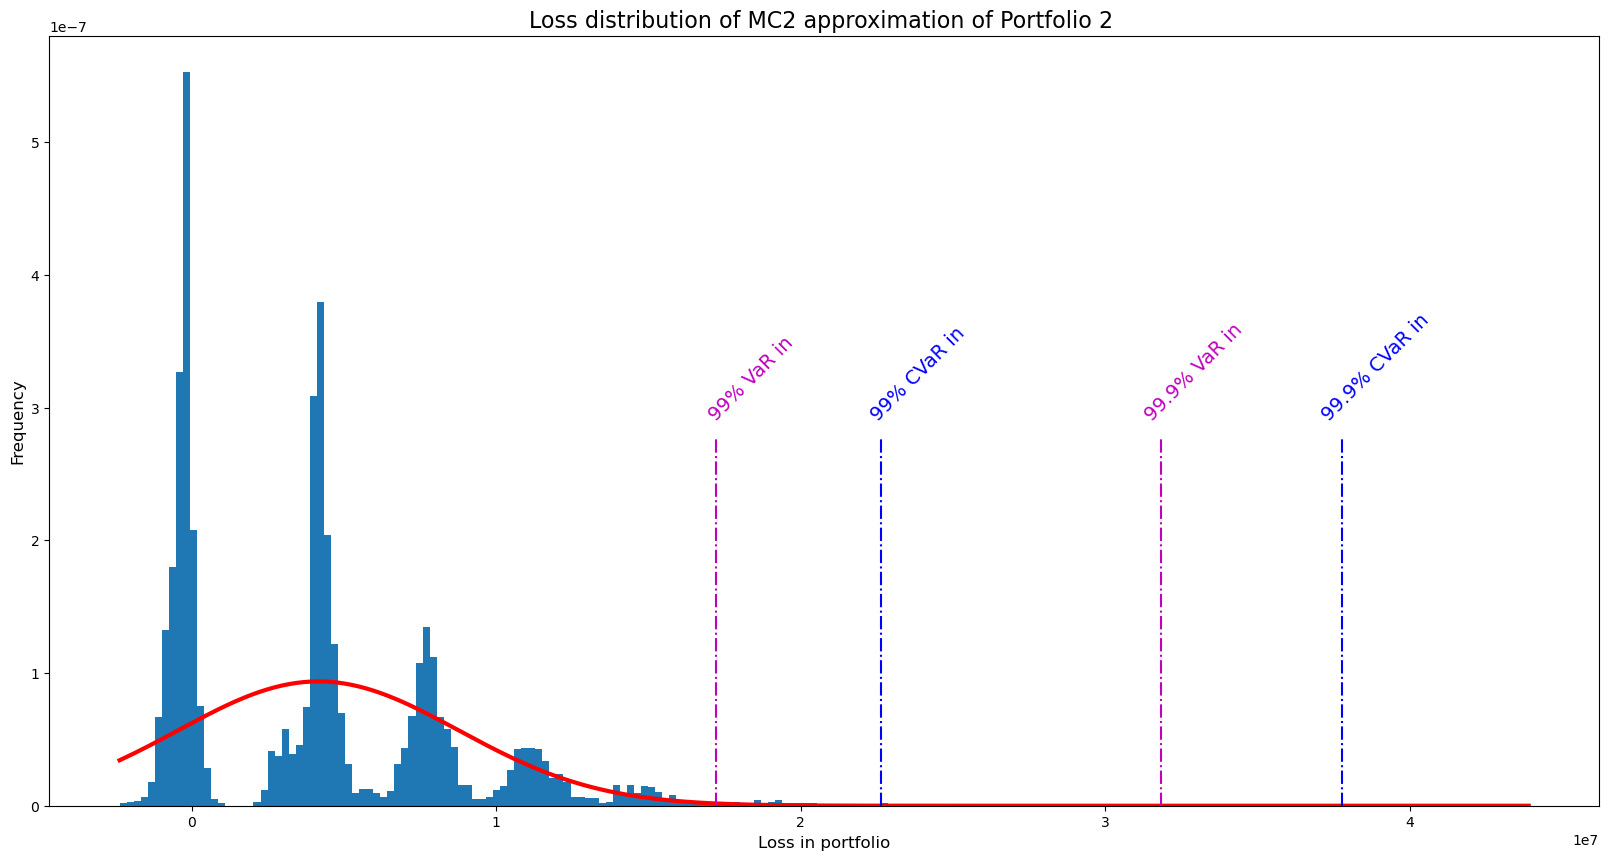

In [60]:
fig = plt.figure(figsize=(20,10))
count, bins, ignored = plt.hist(np.dot(Losses_inMC2,x0[1]), 200, density=True) # In your plot, you need to use Loss * X0[] to replace s
# Plot the Normal curve 
norm = (1/(np.std(np.dot(Losses_inMC2,x0[1]))*math.sqrt(2*math.pi))) * np.exp(-0.5*((bins-np.mean(np.dot(Losses_inMC2,x0[1])))/np.std(np.dot(Losses_inMC2,x0[1])))**2)
norm = norm * sum(count) / sum(norm)
plt.plot(bins, norm, color='r', linewidth= 3)

#non - normal approximation
#99 VaR
plt.plot([np.mean(VaRinMC2[1, 0]), np.mean(VaRinMC2[1, 0])],[0,max(count)/2],color='m',linewidth=1.5,linestyle='-.')
# 99.9 VaR
plt.plot([np.mean(VaRinMC2[1, 1]), np.mean(VaRinMC2[1, 1])], [0, max(count)/2], color='m',linewidth=1.5,linestyle='-.')
# 99 CVaR
plt.plot([np.mean(CVaRinMC2[1, 0]), np.mean(CVaRinMC2[1, 0])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')
#99.9 CVaR
plt.plot([np.mean(CVaRinMC2[1, 1]), np.mean(CVaRinMC2[1, 1])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')

#text
plt.text( 0.98*np.mean(VaRinMC2[1, 0]), max(count)/1.9, '99% VaR in ',fontsize=14, rotation=45,color='m')
plt.text(0.98 *np.mean(VaRinMC2[1, 1]), max(count) / 1.9, '99.9% VaR in',fontsize=14, rotation=45,color='m')
plt.text( 0.98* np.mean(CVaRinMC2[1, 0]), max(count)/1.9, '99% CVaR in',fontsize=14, rotation=45,color='b')
plt.text( 0.98* np.mean(CVaRinMC2[1, 1]), max(count)/1.9, '99.9% CVaR in',fontsize=14, rotation=45,color='b')

plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of MC2 approximation of Portfolio 2 ',fontsize=16)
plt.show()



## True loss distribution, portfolio 1

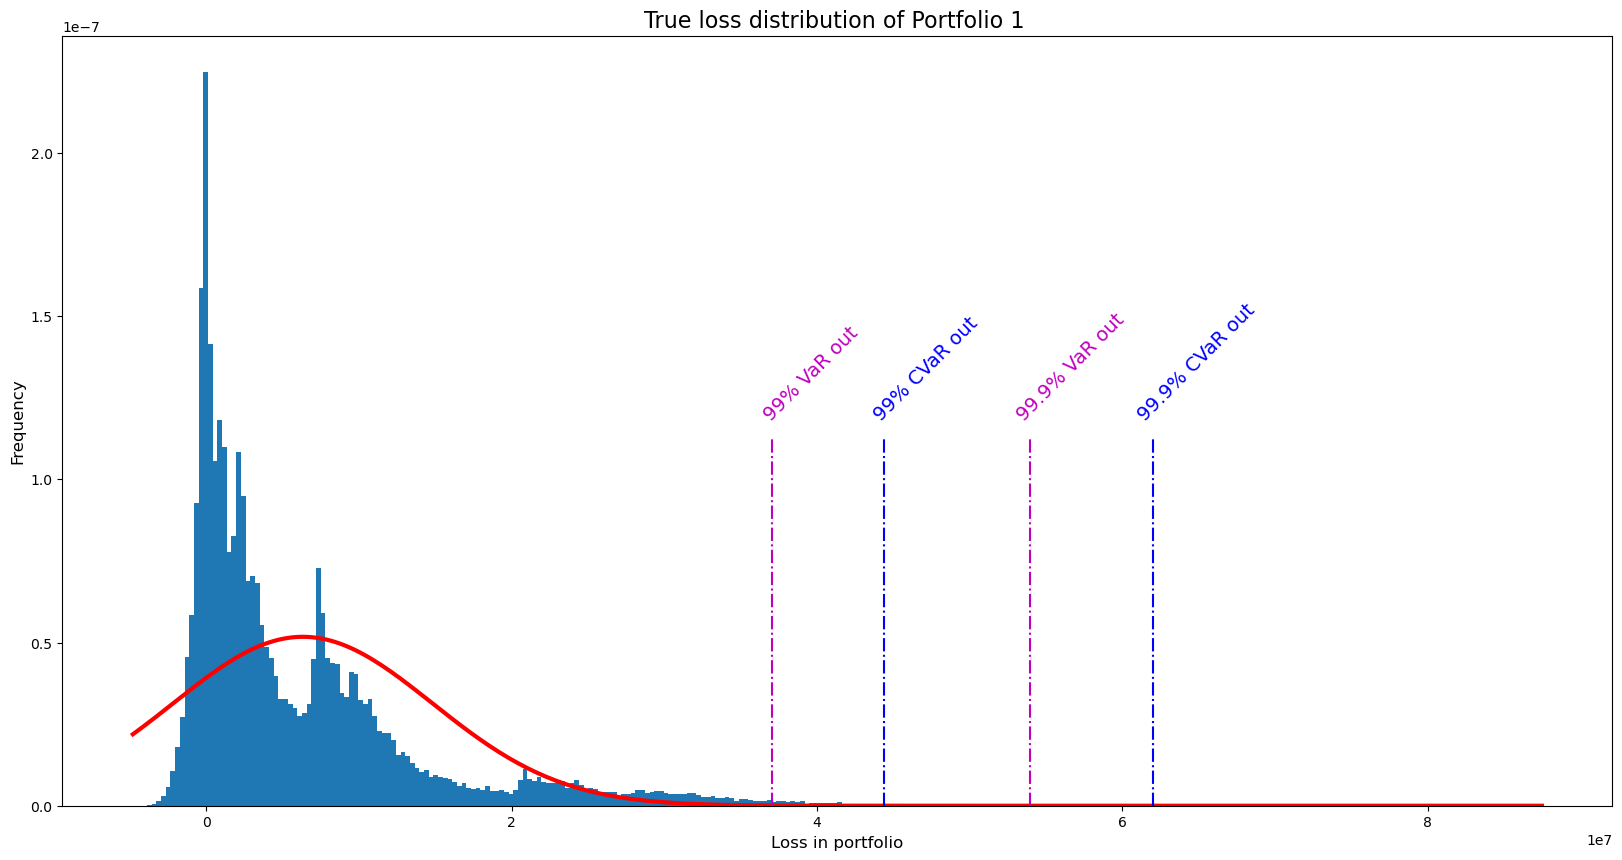

In [57]:
fig = plt.figure(figsize=(20,10))
count, bins, ignored = plt.hist(np.dot(Losses_out,x0[0]), 300, density=True) # In your plot, you need to use Loss * X0[] to replace s
# Plot the Normal curve 
norm = (1/(np.std(np.dot(Losses_out,x0[0]))*math.sqrt(2*math.pi))) * np.exp(-0.5*((bins-np.mean(np.dot(Losses_out,x0[0])))/np.std(np.dot(Losses_out,x0[0])))**2)
norm = norm * sum(count) / sum(norm)
plt.plot(bins, norm, color='r', linewidth= 3)

#non - normal approximation
#99 VaR
plt.plot([np.mean(VaRout[0, 0]), np.mean(VaRout[0, 0])],[0,max(count)/2],color='m',linewidth=1.5,linestyle='-.')
# 99.9 VaR
plt.plot([np.mean(VaRout[0, 1]), np.mean(VaRout[0, 1])], [0, max(count)/2], color='m',linewidth=1.5,linestyle='-.')
# 99 CVaR
plt.plot([np.mean(CVaRout[0, 0]), np.mean(CVaRout[0, 0])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')
#99.9 CVaR
plt.plot([np.mean(CVaRout[0, 1]), np.mean(CVaRout[0, 1])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')

#text
plt.text( 0.98*np.mean(VaRout[0, 0]), max(count)/1.9, '99% VaR out',fontsize=14, rotation=45,color='m')
plt.text(0.98 *np.mean(VaRout[0, 1]), max(count) / 1.9, '99.9% VaR out',fontsize=14, rotation=45,color='m')
plt.text( 0.98* np.mean(CVaRout[0, 0]), max(count)/1.9, '99% CVaR out',fontsize=14, rotation=45,color='b')
plt.text( 0.98* np.mean(CVaRout[0, 1]), max(count)/1.9, '99.9% CVaR out',fontsize=14, rotation=45,color='b')

plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('True loss distribution of Portfolio 1 ',fontsize=16)
plt.show()



## True loss distribution, portfolio 2

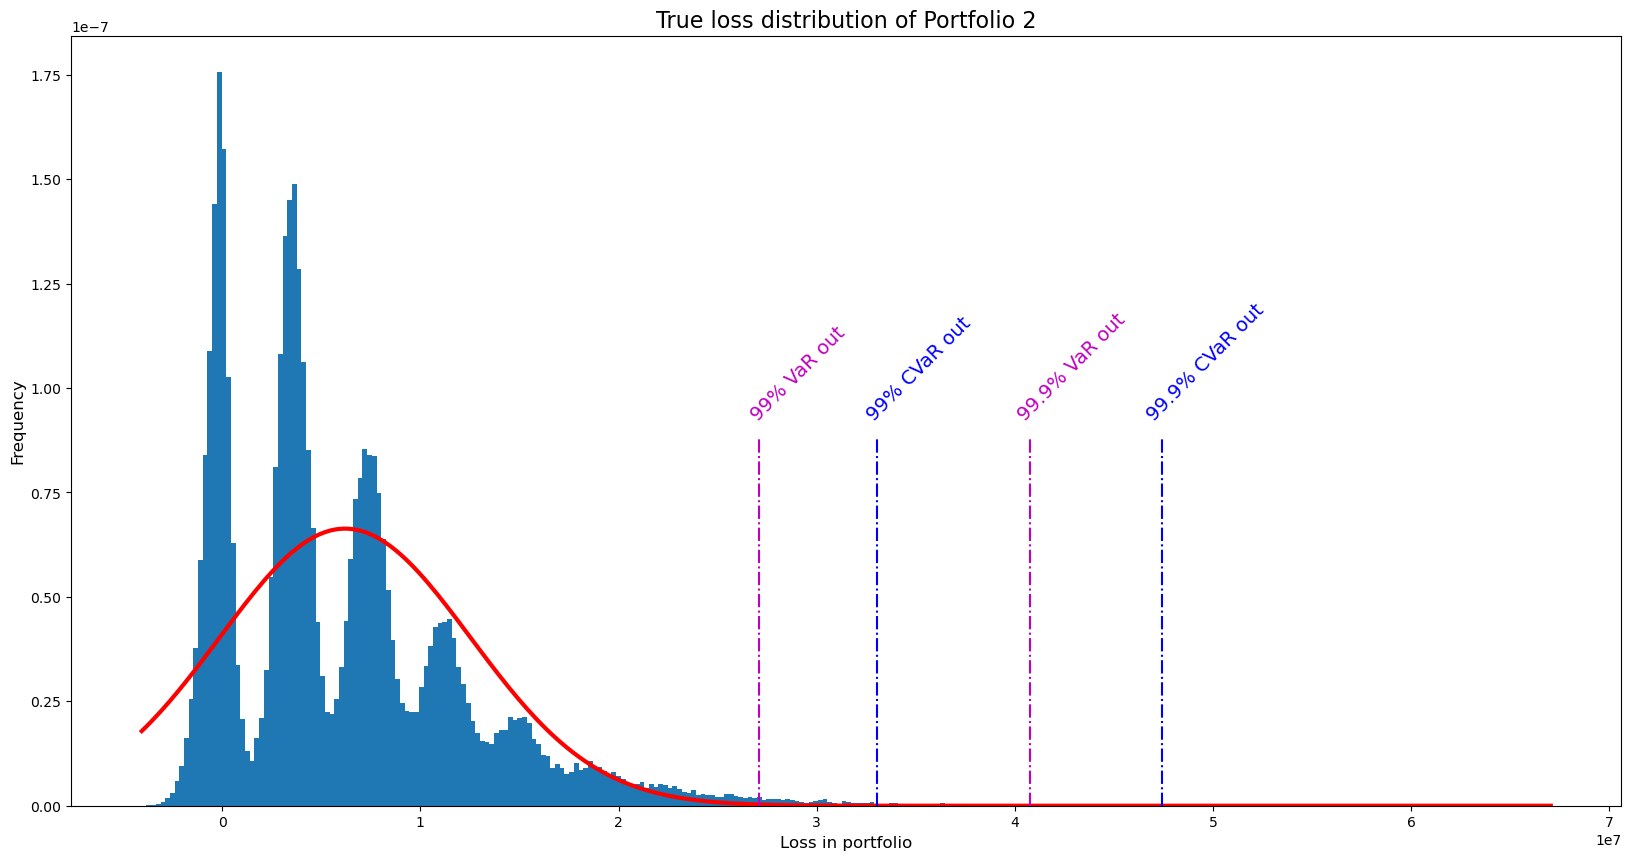

In [61]:
fig = plt.figure(figsize=(20,10))
count, bins, ignored = plt.hist(np.dot(Losses_out,x0[1]), 300, density=True) # In your plot, you need to use Loss * X0[] to replace s
# Plot the Normal curve 
norm = (1/(np.std(np.dot(Losses_out,x0[1]))*math.sqrt(2*math.pi))) * np.exp(-0.5*((bins-np.mean(np.dot(Losses_out,x0[1])))/np.std(np.dot(Losses_out,x0[1])))**2)
norm = norm * sum(count) / sum(norm)
plt.plot(bins, norm, color='r', linewidth= 3)

#non - normal approximation
#99 VaR
plt.plot([np.mean(VaRout[1, 0]), np.mean(VaRout[1, 0])],[0,max(count)/2],color='m',linewidth=1.5,linestyle='-.')
# 99.9 VaR
plt.plot([np.mean(VaRout[1, 1]), np.mean(VaRout[1, 1])], [0, max(count)/2], color='m',linewidth=1.5,linestyle='-.')
# 99 CVaR
plt.plot([np.mean(CVaRout[1, 0]), np.mean(CVaRout[1, 0])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')
#99.9 CVaR
plt.plot([np.mean(CVaRout[1, 1]), np.mean(CVaRout[1, 1])],[0,max(count)/2],color='b',linewidth=1.5,linestyle='-.')

#text
plt.text( 0.98*np.mean(VaRout[1, 0]), max(count)/1.9, '99% VaR out',fontsize=14, rotation=45,color='m')
plt.text(0.98 *np.mean(VaRout[1, 1]), max(count) / 1.9, '99.9% VaR out',fontsize=14, rotation=45,color='m')
plt.text( 0.98* np.mean(CVaRout[1, 0]), max(count)/1.9, '99% CVaR out',fontsize=14, rotation=45,color='b')
plt.text( 0.98* np.mean(CVaRout[1, 1]), max(count)/1.9, '99.9% CVaR out',fontsize=14, rotation=45,color='b')

plt.xlabel('Loss in portfolio',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('True loss distribution of Portfolio 2',fontsize=16)
plt.show()

## Sampling error, model error

In [49]:
# Build tables for errors
# MC  approximations (16 rows)

# -------- Insert your code here -------- #


In [50]:
#sampling error, non-normal approximation to true loss distribution
## mc1 for portfolio 1
VaR_a1mc1p1 = abs(np.mean(VaRinMC1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
CVaR_a1mc1p1 = abs(np.mean(CVaRinMC1[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100
VaR_a2mc1p1 = abs(np.mean(VaRinMC1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
CVaR_a2mc1p1 = abs(np.mean(CVaRinMC1[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100

## mc1 for portfolio2
VaR_a1mc1p2 = abs(np.mean(VaRinMC1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
CVaR_a1mc1p2 = abs(np.mean(CVaRinMC1[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100
VaR_a2mc1p2 = abs(np.mean(VaRinMC1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
CVaR_a2mc1p2 = abs(np.mean(CVaRinMC1[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100

## mc2 for portfolio 1
VaR_a1mc2p1 = abs(np.mean(VaRinMC2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
CVaR_a1mc2p1 = abs(np.mean(CVaRinMC2[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100
VaR_a2m2p1 = abs(np.mean(VaRinMC2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
CVaR_a2mc2p1 = abs(np.mean(CVaRinMC2[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100

# mc2 for portfolio 2
VaR_a1mc2p2 = abs(np.mean(VaRinMC2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
CVaR_a1mc2p2 = abs(np.mean(CVaRinMC2[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100
VaR_a2mc2p2 = abs(np.mean(VaRinMC2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
CVaR_a2mc2p2 = abs(np.mean(CVaRinMC2[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100

d = {'distribution':['99% MC1 VaR(Portfolio 1)','99% MC1 CVaR(Portfolio 1)','99.9% MC1 VaR(Portfolio 1)','99.9% MC1 CVaR(Portfolio 1)',
                    '99% MC1 VaR(Portfolio 2)','99% MC1 CVaR(Portfolio 2)','99.9% MC1 VaR(Portfolio 2)','99.9% MC1 CVaR(Portfolio 2)',
                    '99% MC2 VaR(Portfolio 1)','99% MC2 CVaR(Portfolio 1)','99.9% MC2 VaR(Portfolio 1)','99.9% MC2 CVaR(Portfolio 1)',
                    '99% MC2 VaR(Portfolio 2)','99% MC2 CVaR(Portfolio 2)','99.9% MC2 VaR(Portfolio 2)','99.9% MC2 CVaR(Portfolio 2)'],
    'sampling error':[VaR_a1mc1p1, CVaR_a1mc1p1, VaR_a2mc1p1, CVaR_a2mc1p1,
                      VaR_a1mc1p2, CVaR_a1mc1p2, VaR_a2mc1p2, CVaR_a2mc1p2,
                      VaR_a1mc2p1, CVaR_a1mc2p1, VaR_a2m2p1, CVaR_a2mc2p1,
                      VaR_a1mc2p2, CVaR_a1mc2p2, VaR_a2mc2p2, CVaR_a2mc2p2]}


In [51]:
df_mc = pd.DataFrame(data = d)
df_mc

,distribution,sampling error
0,99% MC1 VaR(Portfolio 1),0.436191
1,99% MC1 CVaR(Portfolio 1),0.633688
2,99.9% MC1 VaR(Portfolio 1),0.630509
3,99.9% MC1 CVaR(Portfolio 1),2.284513
4,99% MC1 VaR(Portfolio 2),1.329064
5,99% MC1 CVaR(Portfolio 2),1.476920
6,99.9% MC1 VaR(Portfolio 2),0.049306
7,99.9% MC1 CVaR(Portfolio 2),1.724072
8,99% MC2 VaR(Portfolio 1),73.837737
9,99% MC2 CVaR(Portfolio 1),66.140069


In [52]:
# Normal approximations (16 rows)

# -------- Insert your code here -------- #

In [18]:
#model error, normal approximation to true loss distribution
## n1 for portfolio 1
VaR_a1n1p1 = abs(np.mean(VaRinN1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
CVaR_a1n1p1 = abs(np.mean(CVaRinN1[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100
VaR_a2n1p1 = abs(np.mean(VaRinN1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
CVaR_a2n1p1 = abs(np.mean(CVaRinN1[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100

## n1 for portfolio 2
VaR_a1n1p2 = abs(np.mean(VaRinN1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
CVaR_a1n1p2 = abs(np.mean(CVaRinN1[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100
VaR_a2n1p2 = abs(np.mean(VaRinN1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
CVaR_a2n1p2= abs(np.mean(CVaRinN1[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100

## n2 for portfolio 1
VaR_a1n2p1 = abs(np.mean(VaRinN2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
CVaR_a1n2p1 = abs(np.mean(CVaRinN2[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100
VaR_a2n2p1 = abs(np.mean(VaRinN2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
CVaR_a2n2p1 = abs(np.mean(CVaRinN2[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100

# n2 for portfolio 2
VaR_a1n2p2 = abs(np.mean(VaRinN2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
CVaR_a1n2p2 = abs(np.mean(CVaRinN2[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100
VaR_a2n2p2 = abs(np.mean(VaRinN2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
CVaR_a2n2p2= abs(np.mean(CVaRinN2[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100

d2 = {'distribution':['99% N1 VaR(Portfolio 1)','99% N1 CVaR(Portfolio 1)','99.9% N1 VaR(Portfolio 1)','99.9% N1 CVaR(Portfolio 1)',
                    '99% N1 VaR(Portfolio 2)','99% N1 CVaR(Portfolio 2)','99.9% N1 VaR(Portfolio 2)','99.9% N1 CVaR(Portfolio 2)',
                    '99% N2 VaR(Portfolio 1)','99% N2 CVaR(Portfolio 1)','99.9% N2 VaR(Portfolio 1)','99.9% N2 CVaR(Portfolio 1)',
                    '99% N2 VaR(Portfolio 2)','99% N2 CVaR(Portfolio 2)','99.9% N2 VaR(Portfolio 2)','99.9% N2 CVaR(Portfolio 2)'],
    'sampling error':[VaR_a1n1p1, CVaR_a1n1p1, VaR_a2n1p1, CVaR_a2n1p1,
                      VaR_a1n1p2, CVaR_a1n1p2, VaR_a2n1p2, CVaR_a2n1p2,
                      VaR_a1n2p1, CVaR_a1n2p1, VaR_a2n2p1, CVaR_a2n2p1,
                      VaR_a1n2p2, CVaR_a1n2p2, VaR_a2n2p2, CVaR_a2n2p2]}


In [19]:
df_N = pd.DataFrame(data = d2)
df_N

,distribution,sampling error
0,99% N1 VaR(Portfolio 1),29.313825
1,99% N1 CVaR(Portfolio 1),41.278841
2,99.9% N1 VaR(Portfolio 1),39.389228
3,99.9% N1 CVaR(Portfolio 1),49.962266
4,99% N1 VaR(Portfolio 2),21.974888
5,99% N1 CVaR(Portfolio 2),35.991893
6,99.9% N1 VaR(Portfolio 2),36.208123
7,99.9% N1 CVaR(Portfolio 2),48.206483
8,99% N2 VaR(Portfolio 1),76.693477
9,99% N2 CVaR(Portfolio 1),93.734180
